TO DO TOMORROW.

Run below block with worm. Check all the output files. Then write for fresh expts not based on already-collected dataframe. 

In [1]:
import multiprocessing 
import numpy as np
import os

import model_based_agent as mba 
import worm_env as we 

import utils as ut
import tab_agents as tab
from datetime import datetime 

init_df = './nogap_traj_df.pkl'
folder = './Data/Reals'+datetime.now().strftime('%d-%m-%H-%M')
fbase = folder+'/realworm_'
if os.path.isdir(folder):
    os.rmdir(folder)
os.mkdir(folder)

num_learners = 2
collection_eps = 2
eps_vector = np.ones(collection_eps)
eps_vector[::2] -= .95

gamma=.25
epsilon=.05
alpha=.01


if __name__=='__main__':
    
    '''
    At the end of this script, there will be files in a timestamped folder:
    1. Saved trajectory combined with old ('..total.pkl')
    2. Saved individual trajectory files ('..eval_start.pkl', '..[ep].pkl')
    3. Averaged agent from each each full worm episode ('..[ep]_agent.pkl')
    '''

    # Start real worm environment
    worm = we.ProcessedWorm(0,ep_len=50,bg_time=3) 
    worm_agent = tab.Q_Alpha_Agent(gamma=0, epsilon=0.05, alpha=0) # Agent doesn't learn
    # Start model environments and learners 
    dh = mba.DataHandler()
    dh.load_df(init_df)
    
    for loop in range(collection_eps):
        fname = fbase+str(loop)+'.pkl'
        
        # Make new learner list based on newest data
        learners = mba.make_learner_list(num_learners, 
                                gamma=gamma, epsilon=epsilon, alpha=alpha, q_checkpoint=worm_agent.Qtab)
        runner = mba.WormRunner(worm_agent,worm)
        
        
        # Start multiprocessing
        manager = multiprocessing.Manager()
        poison_queue = manager.Queue()
        pool = multiprocessing.Pool()
        
        # Run main functions: train agents and collect more data
        lea_outs = []
        print('learning')
        for lea in learners:
            lea_outs.append(pool.apply_async(lea.learn, [dh],{'poison_queue':poison_queue}))
        runner_out = pool.apply_async(runner.full_run,[1,fname],
                                      {'eps_vector':eps_vector,'eval_len':30,'poison_queue':poison_queue})
        # Wait for them to finish
        pool.close()
        pool.join()
        for lea_out in lea_outs:
            if lea_out.successful() is False:
                raise Exception('One learner failed')
        if runner_out.successful() is False:
            raise Exception('Runner failed')
        
        # Combining learners from run
        worm_agent.Qtab = mba.combine_learners(lea_outs)
        worm_agent.save(fname[:-4]+'_agent.pkl')
        
        # Take new data and add to DataHandler. 
        dh.add_dict_to_df([fname])
        # Check if worm is tired
        #runner.check_if_tired(fname,active_for=.25)

        
    # Final saves and closes
    worm_agent.Qtab = mba.combine_learners(lea_outs)
    worm_agent.save(fbase+str(collection_eps)+'_agent.pkl')
    runner.close()
    # Save all new collected data plus old in one dataframe
    dh.save_dfs(fbase+'total.pkl')

ModuleNotFoundError: No module named 'fake_worm'

# This code is for collecting an initial dataframe

In [20]:
import numpy as np
import os

import model_based_agent as mba 
import worm_env as we 
from datetime import datetime 

folder = './Data/Reals20-12-14-58' #'./Data/Reals'+datetime.now().strftime('%d-%m-%H-%M')
fbase = folder+'/realworm_'

# if os.path.isdir(folder):
#     os.rmdir(folder)
# os.mkdir(folder)

# Start real worm environment
worm = we.ProcessedWorm(0,ep_len=1200,bg_time=20) 
dh = mba.DataHandler()
init_fname = fbase+'init_dict0.pkl'

# 5 episodes with ep_len=1200 is about 20 minutes.
mba.get_init_traj(init_fname, worm, 10, act_rate=3)
dh.add_dict_to_df([init_fname],reward_ahead=10, 
                    timestep_gap=1, 
                    prev_act_window=1, 
                    jump_limit=100,)
dh.save_dfs(fbase+'init_df0.pkl')


C:\Users\ccli3\Documents\Research\20_09_07_NewPC\RLWorms\12_19_realworms\improc.py:196: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


In [1]:
from improc import *
cam,task = init_instruments()

In [2]:
task.write(0)
task.close()

# Checking output section

In [21]:
import pickle
import matplotlib.pyplot as plt

In [27]:
with open('./Data/Reals20-12-14-58/realworm_init_df0.pkl','rb') as f:
    traj_df = pickle.load(f)

In [26]:
len(traj_df['reward'])

12000

In [29]:
traj_df

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc
0,0.546,60,30,1,60,30,0.380682,"[995.0, 844.0]"
1,0.718,60,30,1,60,30,0.529412,"[995.25, 844.125]"
2,0.906,60,30,1,60,60,0.654412,"[994.2, 843.6666666666666]"
3,1.093,60,60,0,60,30,0.416667,"[994.1428571428571, 843.5]"
4,1.281,60,30,0,60,30,0.166667,"[994.3125, 843.5]"
...,...,...,...,...,...,...,...,...
10898,212.438,30,30,1,30,30,0.979021,"[955.2619047619048, 844.7619047619048]"
10899,212.594,30,30,0,30,30,0.261905,"[954.9024390243902, 844.9512195121952]"
10900,212.781,30,30,0,30,30,-0.584740,"[954.775, 845.15]"
10901,212.953,30,30,0,30,30,-0.635256,"[955.078947368421, 844.8421052631579]"


In [11]:
dh = mba.DataHandler()
dh.load_df('./Data/Reals20-12-14-28/realworm_init_df.pkl')

In [17]:
learner = mba.Learner(worm_agent,'test',worm_pars={'num_models':1,'frac':1})

In [18]:
learner.modset.make_models(dh,sm_pars={'lambda':.05,'iters':0})

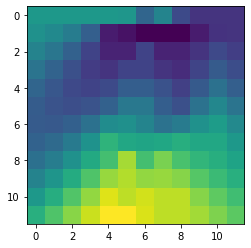

In [20]:
plt.imshow(learner.modset.models[0]['body_on'][:,:,0])

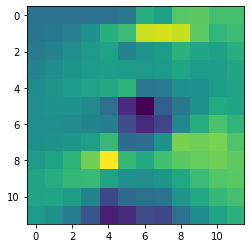

In [26]:
plt.imshow(learner.modset.models[0]['reward_on'][:,:,0])

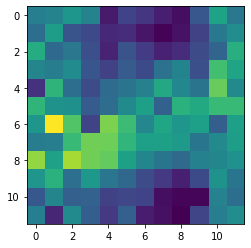

In [4]:
plt.imshow(traj.Qtab[:,1].reshape(12,12))

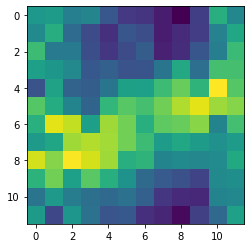

In [7]:
plt.imshow(traj.Qtab[:,1].reshape(12,12))

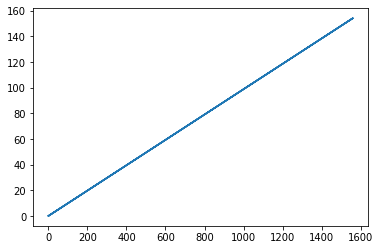

In [11]:
locs = np.zeros((len(traj['loc']),2))
for i in range(len(traj['loc'])):
    locs[i,:] = traj['loc'][i]
plt.plot(locs[:,0],locs[:,1])